In [9]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [48]:
num_points = 15
side_length = 10**3
N = 6  # Виленский

x_coords = np.random.uniform(0, side_length, num_points)
y_coords = np.random.uniform(0, side_length, num_points)

points = list(zip(x_coords, y_coords))

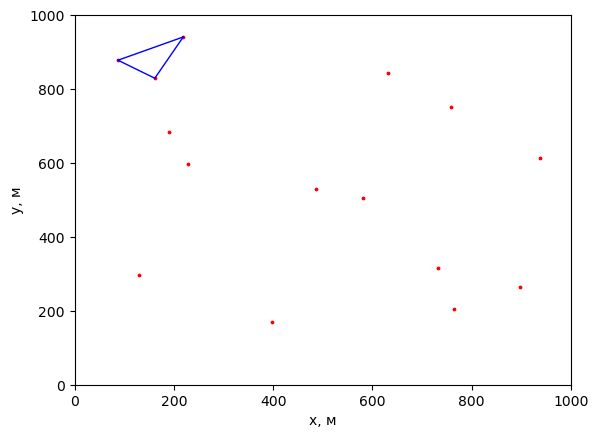

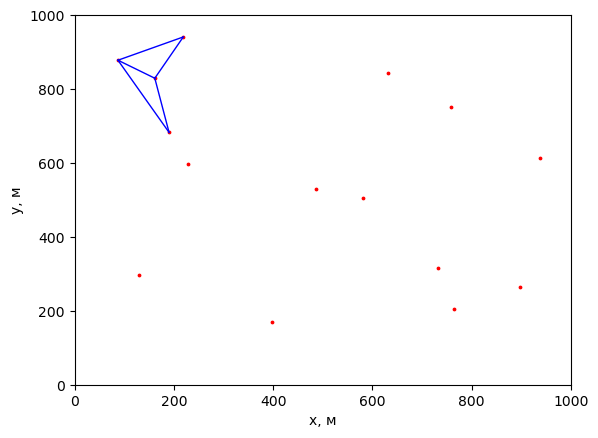

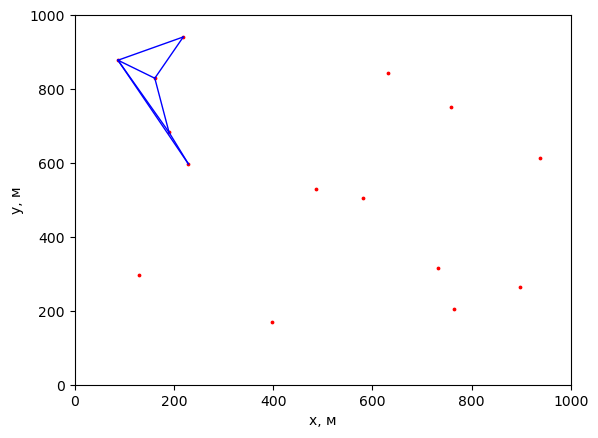

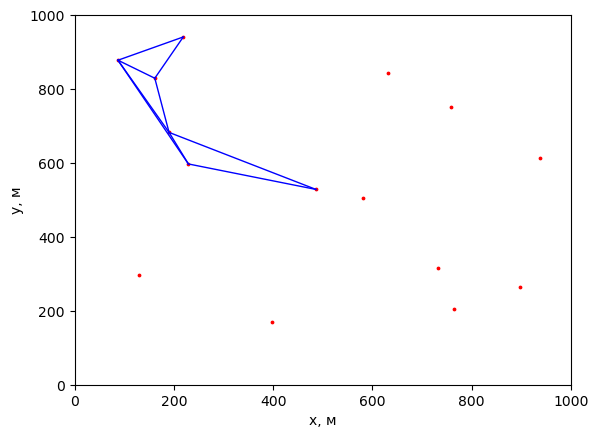

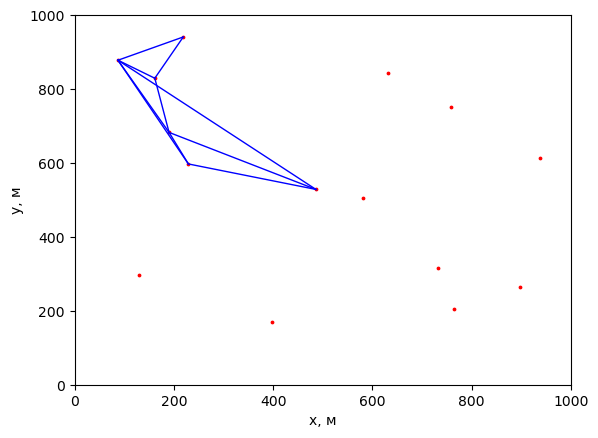

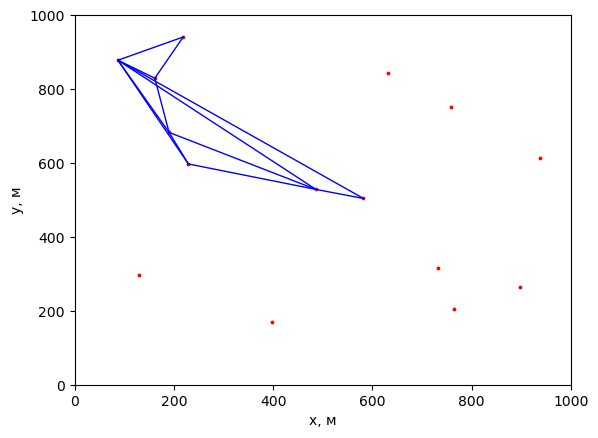

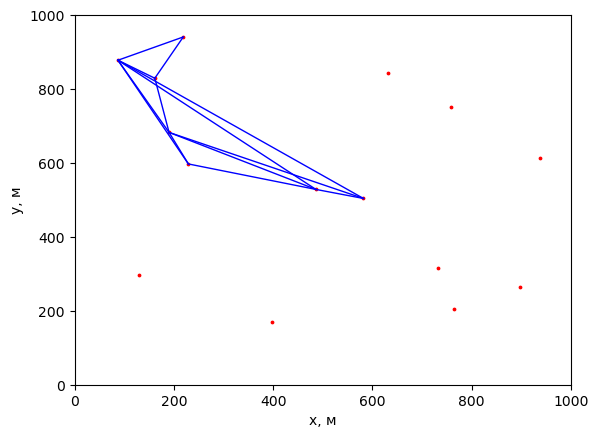

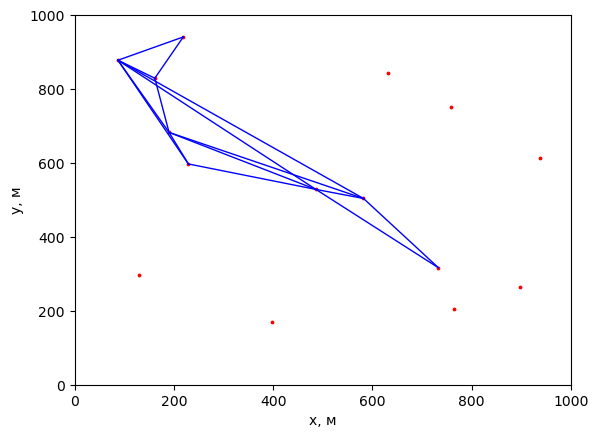

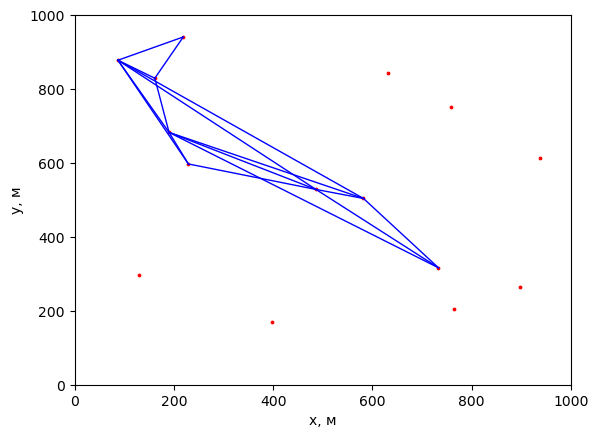

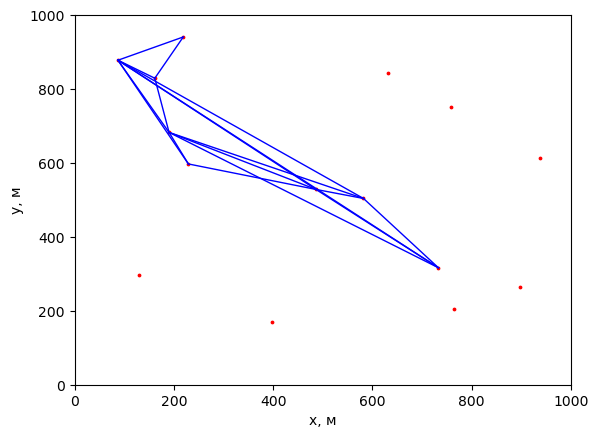

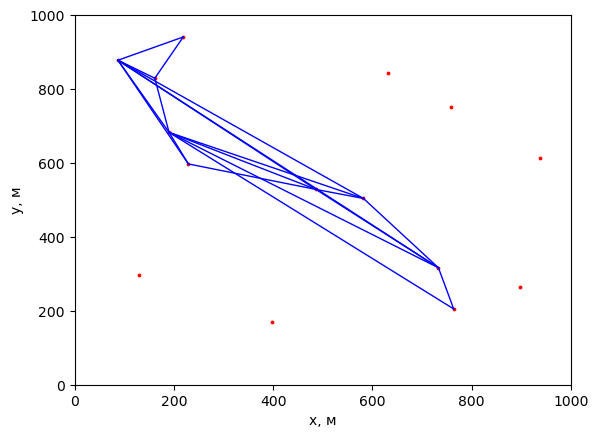

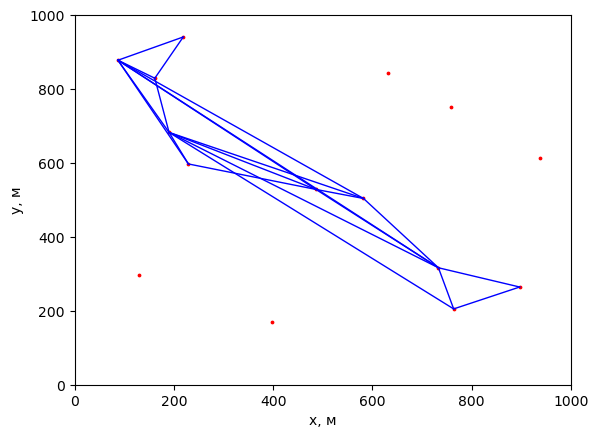

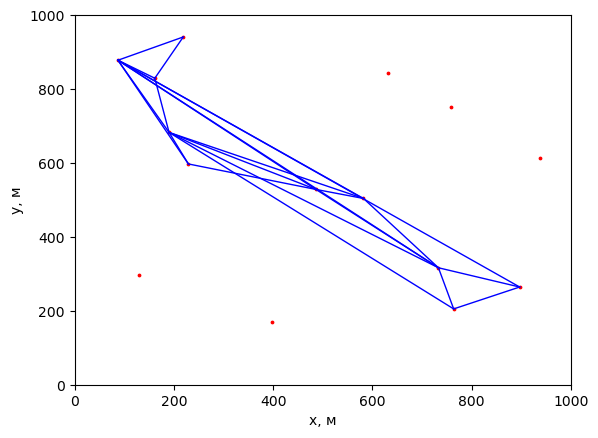

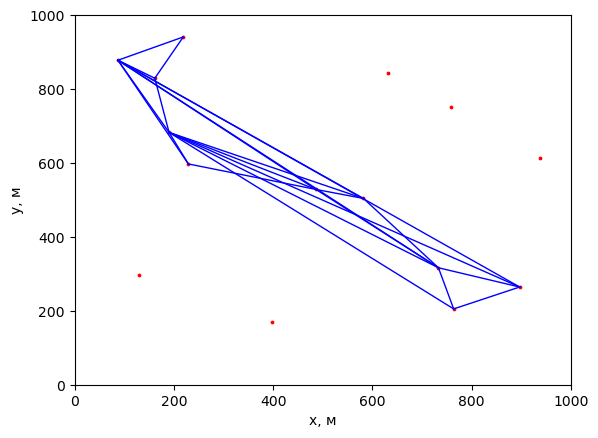

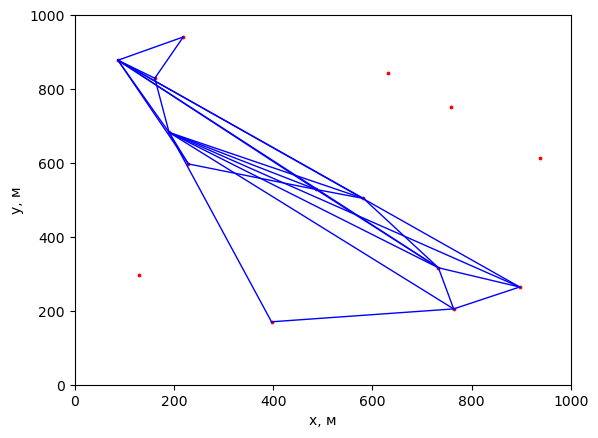

AssertionError: 

In [58]:
def is_point_upper_line(point, line):
    return (
        point[1] >=
        (point[0] - line[0][0]) / (line[1][0] - line[0][0])
        * (line[1][1] - line[0][1]) + line[0][1]
    )

def sqr_dist_between_points(point1, point2):
    return (point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2

def sqr_dist_from_point_to_line(point, line):
    (x0, y0), ((x1, y1), (x2, y2)) = point, sorted(line)

    line_dist = sqr_dist_between_points((x1, y1), (x2, y2))
    assert(line_dist != 0)

    # Укорочение линии для изключения неоднозначных ситуаций 
    x1 -= (x1 - x2) * abs(x1 - x2) / line_dist
    y1 -= (y1 - y2) * abs(y1 - y2) / line_dist
    x2 -= (x2 - x1) * abs(x2 - x1) / line_dist
    y2 -= (y2 - y1) * abs(y2 - y1) / line_dist

    projection = (
        (y2 - y1) * ((y0 - y1) * (x2 - x1) - (x0 - x1) * (y2 - y1)) / line_dist + x0,
        (x2 - x1) * ((x0 - x1) * (y2 - y1) - (y0 - y1) * (x2 - x1)) / line_dist + y0
    )

    if projection[0] > x2:
        return sqr_dist_between_points((x0, y0), (x2, y2))
    if projection[0] < x1:
        return sqr_dist_between_points((x0, y0), (x1, y1))
    return sqr_dist_between_points((x0, y0), projection)

def cos_angle_between_three_points(point1, point2, point3):
    vector1 = (point1[0] - point2[0], point1[1] - point2[1])
    vector2 = (point3[0] - point2[0], point3[1] - point2[1])
    return (
        (vector1[0] * vector2[0] + vector1[1] * vector2[1])
        / (vector1[0] ** 2 + vector1[1] ** 2) ** .5
        / (vector2[0] ** 2 + vector2[1] ** 2) ** .5
    )

def get_number_sign(number):
    return -1 if number < 0 else 1

def get_correct_edge(point1, point2):
    return tuple(sorted((point1, point2)))

def get_next_outline_point(point1, point2):
    assert(edges[get_correct_edge(point1, point2)] >= 1)
    return next(filter(
        lambda connected_point:
            edges[get_correct_edge(connected_point, point2)] >= 1
            and point2 != point1,
        connected_points[point2]
    ))

def draw():
    for (x1, y1), (x2, y2) in edges:
        plt.plot((x1, x2), (y1, y2), linewidth=1, color='blue')

    plt.scatter(x_coords, y_coords, s=3, color='red')

    plt.xlim(0, side_length)
    plt.ylim(0, side_length)
    plt.xlabel('x, м')
    plt.ylabel('y, м')

    plt.show()


first_edge = get_correct_edge(points[0], min(
    points[1:],
    key=lambda point: sqr_dist_between_points(points[0], point)
))

# У начального ребра две свободные стороны
edges = {first_edge: 2}

connected_points = {first_edge[0]: {first_edge[1]}, first_edge[1]: {first_edge[0]}}

# Расстояния от неиспользованных точек до фигуры
dists_points_to_outline = {
    point: (first_edge, sqr_dist_from_point_to_line(point, first_edge))
    for point in points if point not in connected_points
}

while len(dists_points_to_outline) != 0:
    nearest_point = min(dists_points_to_outline, key=lambda point: dists_points_to_outline[point][1])
    
    # Побдираем ближайшую грань из перимерта
    min_dist_edge = dists_points_to_outline[nearest_point][0]

    # Добавляем новые ребра в общий учет
    new_egde_first = get_correct_edge(nearest_point, min_dist_edge[0])
    new_egde_second = get_correct_edge(nearest_point, min_dist_edge[1])

    edges[new_egde_first] = 1
    edges[new_egde_second] = 1
    edges[min_dist_edge] -= 1

    connected_points[nearest_point] = {*min_dist_edge}
    connected_points[min_dist_edge[0]].add(nearest_point)
    connected_points[min_dist_edge[1]].add(nearest_point)

    del dists_points_to_outline[nearest_point]
    for point in dists_points_to_outline:
        dists_points_to_outline[point] = min(
            dists_points_to_outline[point],
            (new_egde_first, sqr_dist_from_point_to_line(point, new_egde_first)),
            (new_egde_second, sqr_dist_from_point_to_line(point, new_egde_second)),
            key=lambda edge_and_dist: edge_and_dist[1]
        )

    # Восстанавливаем выпуклость фигуры
    current_cos_sign = get_number_sign(cos_angle_between_three_points(
        min_dist_edge[1], nearest_point, min_dist_edge[0]
    ))
    first_outline_point = min_dist_edge[0]
    second_outline_point = get_next_outline_point(nearest_point, first_outline_point)
    while (
        current_cos_sign != get_number_sign(cos_angle_between_three_points(
            nearest_point, first_outline_point, second_outline_point
        ))
    ):
        # clear_output(wait=True)
        draw()
        time.sleep(1)

        new_edge = get_correct_edge(nearest_point, second_outline_point)

        edges[new_edge] = 1
        edges[get_correct_edge(nearest_point, first_outline_point)] -= 1
        
        connected_points[second_outline_point].add(nearest_point)
        connected_points[nearest_point].add(second_outline_point)
        
        for point in dists_points_to_outline:
            dists_points_to_outline[point] = min(
                dists_points_to_outline[point],
                (new_edge, sqr_dist_from_point_to_line(point, new_edge)),
                key=lambda edge_and_dist: edge_and_dist[1]
            )

        first_outline_point, second_outline_point = second_outline_point, get_next_outline_point(first_outline_point, second_outline_point)

    current_cos_sign = get_number_sign(cos_angle_between_three_points(
        min_dist_edge[0], nearest_point, min_dist_edge[1]
    ))
    first_outline_point = min_dist_edge[1]
    second_outline_point = get_next_outline_point(nearest_point, first_outline_point)
    while (
        current_cos_sign != get_number_sign(cos_angle_between_three_points(
            nearest_point, first_outline_point, second_outline_point
        ))
    ):
        draw()
        time.sleep(1)    

        new_edge = get_correct_edge(nearest_point, second_outline_point)

        edges[new_edge] = 1
        edges[get_correct_edge(nearest_point, first_outline_point)] -= 1
        
        connected_points[second_outline_point].add(nearest_point)
        connected_points[nearest_point].add(second_outline_point)

        for point in dists_points_to_outline:
            dists_points_to_outline[point] = min(
                dists_points_to_outline[point],
                (new_edge, sqr_dist_from_point_to_line(point, new_edge)),
                key=lambda edge_and_dist: edge_and_dist[1]
            )

        first_outline_point, second_outline_point = second_outline_point, get_next_outline_point(first_outline_point, second_outline_point)

    # clear_output(wait=True)
    draw()
    time.sleep(1)